# Import required Modules
* install scikit-multiflow to import drift detection algorithm
* Mount on google drive to load datasets.

In [ ]:
!pip install -q scikit-multiflow

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skmultiflow.drift_detection import ADWIN, DDM
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter,filterwarnings
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from matplotlib.colors import ListedColormap
from multiprocessing.pool import ThreadPool
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from contextlib import suppress
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from random import shuffle
import seaborn as sns
from time import time
import pandas as pd
import numpy as np
import scipy.io
import pickle
import sys
import gc
import os
import re
# filterwarnings('ignore')
# filterwarnings(action='once')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# simplefilter('ignore', FutureWarning)

In [ ]:
# from IPython.core.interactiveshell import InteractiveShell
# def my_should_run_async(code):
#     return True
# shell = InteractiveShell.instance()
# shell.ast_node_interactivity = "all"
# shell.should_run_async = my_should_run_async

In [ ]:
# import asyncio
# from IPython.core.interactiveshell import InteractiveShell
# async def my_run_async(code):
#     try:
#         result = await asyncio.to_thread(exec, code)
#     except Exception as e:
#         result = str(e)
#     return result
# shell = InteractiveShell.instance()
# shell.run_cell_async = my_run_async

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
code_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Codes/Shared Codes'
data_path = '/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/data'
results_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results"
image_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Images"
csv_path = "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/CSV"
folders = ["gp_combiner_with_model_replacement_evolving_random_forest","gp_combiner_with_model_replacement_evolving_DFS",
           "faoselm_gp_combiner_with_model_replacement_evolving_random_forest","faoselm_gp_combiner_with_model_replacement_evolving_DFS",
           "kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest","kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS"]
# sys.path.insert(0,code_path)
# from ensemble import Ensemble, Classifier

# Componentes

In [ ]:
filenames = ['kddcup99_csv.csv','ISCX2012.csv','CSE-CIC2018.csv','CICIDS2017.csv','7recurrentDrift.csv', 'blip.csv', 'incrementalDrift.csv',
             '7gradualDrift.csv', '7suddenDrift.csv']
filenames = list(map(lambda x: os.path.join(data_path, x), filenames))

In [ ]:
def save_pickle(obj, file_name):
  with open(file_name, 'wb') as f:
    pickle.dump(obj, f)
def load_pickle(file_name):
  with open(file_name, 'rb') as f:
    d = pickle.load(f)
  return d

# Result Visulization Section


In [ ]:
# def load_pickle(file_name):
#     with open(file_name, 'rb') as f:
#       d = pickle.load(f)
#       if len(d.keys()) > 1:
#         dd = {}
#         dd['dataset'] = d
#         return dd
#       return d

In [ ]:
def load_time_serires_data(data_path):
    data = load_pickle("{}".format(data_path))
    y_true, y_pred = [], []
    for key in data.keys():
        for i in range(1, len(data[key])):
          f = data[key][i]
          try:
            y_true.append(np.array(f['y_true'].tolist()).astype('int'))
            y_pred.append(np.array(f['y_pred'].tolist()).astype('int'))
          except:
            y_true.append(np.array(f['y_true']).astype('int'))
            y_pred.append(np.array(f['y_pred']).astype('int'))
    return y_true, y_pred

def load_time_serires_data(data_path):
    data = load_pickle("{}".format(data_path))
    y_true, y_pred = [], []
    for key in data.keys():
        for i in range(1, len(data[key].keys())):
          f = data[key][i]
          try:
            y_true += f['y_true'].tolist()
            y_pred += f['y_pred'].tolist()
          except:
            y_true += f['y_true']
            y_pred += f['y_pred']
    return np.array(y_true).astype('int'), np.array(y_pred).astype('int')

In [ ]:
def read_drift_location_data(data_path, step_size):
    data = load_pickle(data_path)
    for key in data:
        drift_locations = list(data[key].keys())
    drift_locations.sort()
    drift_locations__ = []
    # for i in range(0, len(drift_locations)):
    #     print("123")
    #     if drift_locations[i] - drift_locations[i-1] > 5000 and drift_locations[i] < 80000:
    #       print("456")
    #       drift_locations__.append(drift_locations[i])
    #       print("789")
    # print(3,drift_locations__)
    return drift_locations # drift_locations__

In [ ]:
metric_functions = {'accuracy': accuracy_score, 'precision': precision_score,
                        'recall': recall_score, 'f1_score': f1_score, 'auc': roc_auc_score}
def cummulative_metrics(y_true, y_pred, step_size, metric):

    metric_score = []
    for i in range(step_size, len(y_true)-step_size, step_size):
        try:
          if metric == 'accuracy':
            metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i]))
          else:
            metric_score.append(metric_functions[metric](y_true[:i], y_pred[:i], average='macro'))
        except:
          metric_score.append(0.5)
    return metric_score

In [ ]:
def time_series_plot(data_path, drift_data_path, step_size, title, metric, method_names):
    numerecal_results = pd.DataFrame()
    if type(data_path) is not list:
      method_names = [method_names]
      data_path = [data_path]
    fig = plt.figure(figsize=(12, 8))
    colors = ['red', 'green', 'blue', 'magenta', 'pink','saddlebrown','darkorange','indigo']
    j = 0
    for d_path, method_name, path in zip(data_path, method_names, drift_data_path):
        # print(method_name)
        y_true, y_pred = load_time_serires_data(d_path)
        metric_score = cummulative_metrics(y_true, y_pred, step_size, metric)
        # if method_name == "GPC-FOS DFS" or method_name == "GPC-FOS RandomForest":
        #   metric_score = np.array(metric_score)+0.009
        numerecal_results[method_name] = metric_score
        X = np.linspace(0, 80000, len(metric_score))
        plt.plot(X, metric_score, label='{}'.format(method_name), color=colors[j]) #
        drift_locations  = read_drift_location_data(path, step_size)
        for loc in drift_locations:
          X_diff = np.abs(X - loc)
          closest_point = X_diff.argmin()
          y_value = metric_score[closest_point]
          plt.plot(loc, y_value, marker="o", markersize=9, markerfacecolor=colors[j]) #
        j += 1
    # plt.xlabel("Time Series")
    plt.xlabel("Number of Samples")
    plt.ylabel("{}".format(metric))
    plt.title(title[0]+" ")
    plt.legend(loc='best')
    os.makedirs(os.path.join(image_path,"{}".format(title[1])), exist_ok=True)
    numerecal_results.to_csv(os.path.join(image_path,"{}/{}_{}.csv".format(title[1],title[0], metric)), index=False)
    plt.savefig(os.path.join(image_path,"{}/{}_{}.png".format(title[1],title[0], metric)))
    plt.savefig(os.path.join(image_path,"{}/{}_{}.svg".format(title[1],title[0], metric)))
    plt.show()

In [ ]:
plt.style.use('ggplot')
def bar_chart_plot(data_path, title, metric, method_names, xticks):
    if type(data_path) is not list:
      method_names = [method_names]
      data_path = [data_path]
    heights = []
    fig = plt.figure(figsize=(15, 12))
    data_path = np.split(np.array(data_path), len(xticks))

    for d_path in data_path:
        h = []
        for path in d_path:
          y_true, y_pred = load_time_serires_data(path)
          h.append(metric_functions[metric](y_true, y_pred))
        heights.append(h)
    width = 0.7
    # print(len(heights))
    X = np.array([0.1, 0.2, 0.3, 0.4, 0.5,0.6,0.7,0.8,0.9])
    colors = ['g', 'r', 'cyan', 'gray', 'y','blue','black','orange','magenta']
    for i in range(len(heights)):
        for j in range(len(method_names)):
          plt.bar(X[j], heights[i][j], width=0.1, color=colors[j])
        X += width
    plt.xlabel("Dataset Names")
    plt.xticks([0.25, 0.95, 1.65, 2.35, 3.05,3.75,4.45,5.85,6.55], xticks)
    plt.ylabel("{}".format(metric))
    plt.title(title)
    plt.legend(method_names,loc='best') #  bbox_to_anchor=(1.1, 1.05),
    plt.savefig(os.path.join(image_path,"{}.png".format(title)))
    plt.savefig(os.path.join(image_path,"{}.svg".format(title)))
    plt.show()

In [ ]:
!pip install -q dataframe_image

In [ ]:
from collections import defaultdict
from pandas.plotting import table
import dataframe_image as dfi
def result_as_df(data_path, metrics, method_names,title):

    result = defaultdict(lambda: [])
    for d_path, method_name in zip(data_path, method_names):
        ############
        for metric in metrics:
          y_true, y_pred = load_time_serires_data(d_path)
          metric_score = metric_functions[metric](y_true, y_pred)
          result[metric].append(metric_score)
    df = pd.DataFrame(result)
    df.index = method_names
    df = df.sort_values(by='f1_score', ascending=False).T
    df.to_csv(os.path.join(csv_path,title+'.csv'))
    return df

In [ ]:
method_names = ["GPC-OS RandomForest","GPC-OS DFS", "GPC-FOS RandomForest","GPC-FOS DFS", "GPC-KOS RandomForest","GPC-KOS DFS"]
metrices = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']

# Gradual Result Visualization




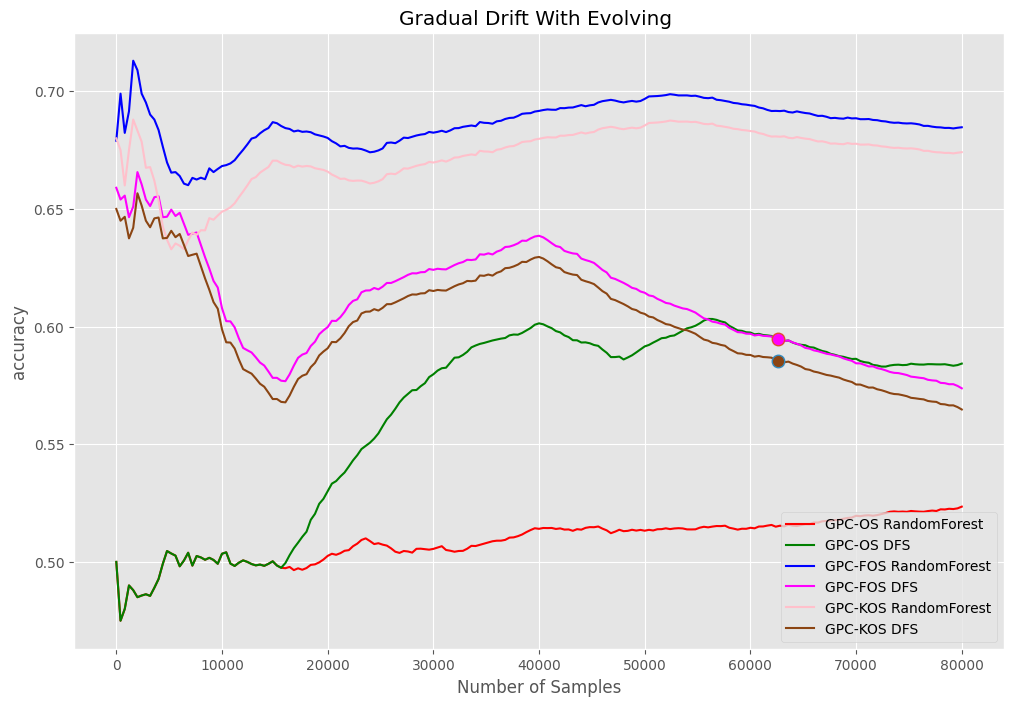

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

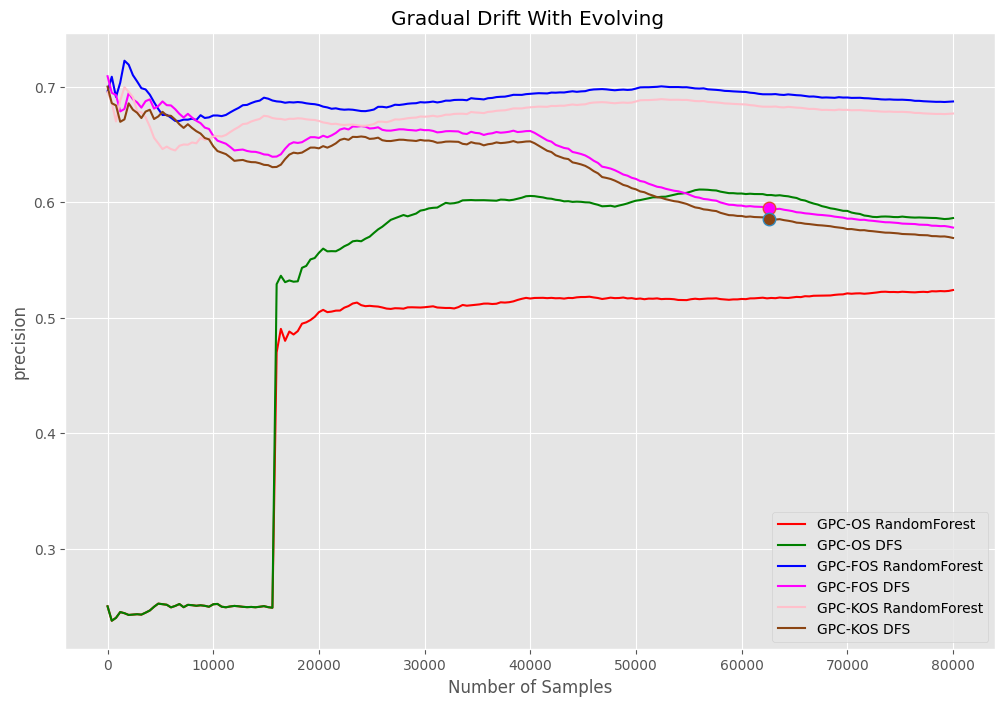

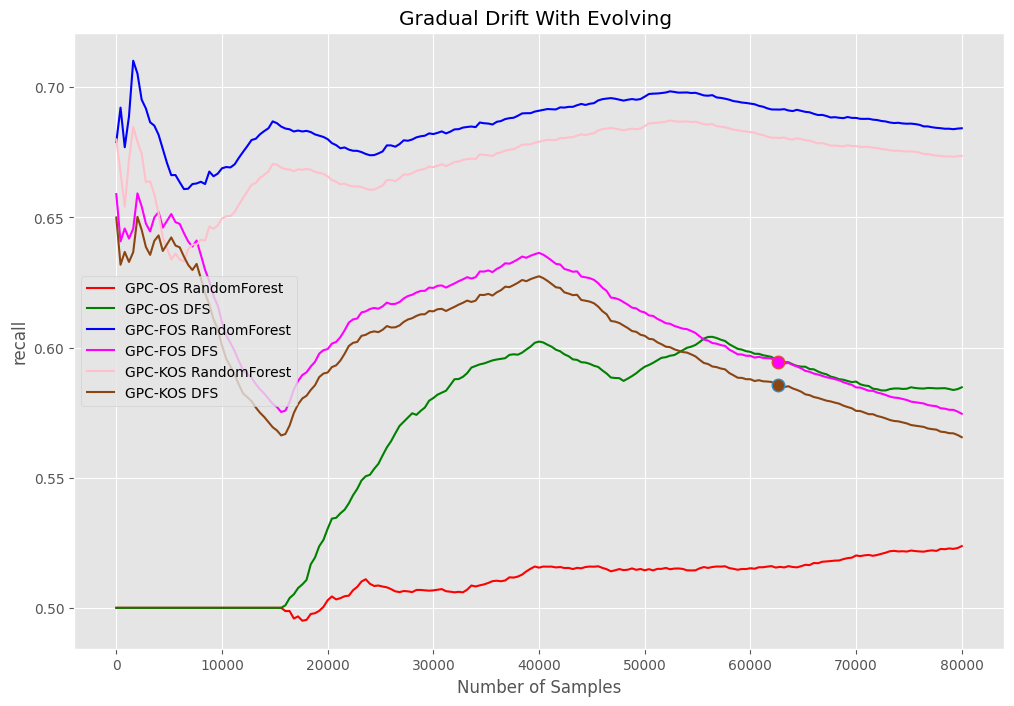

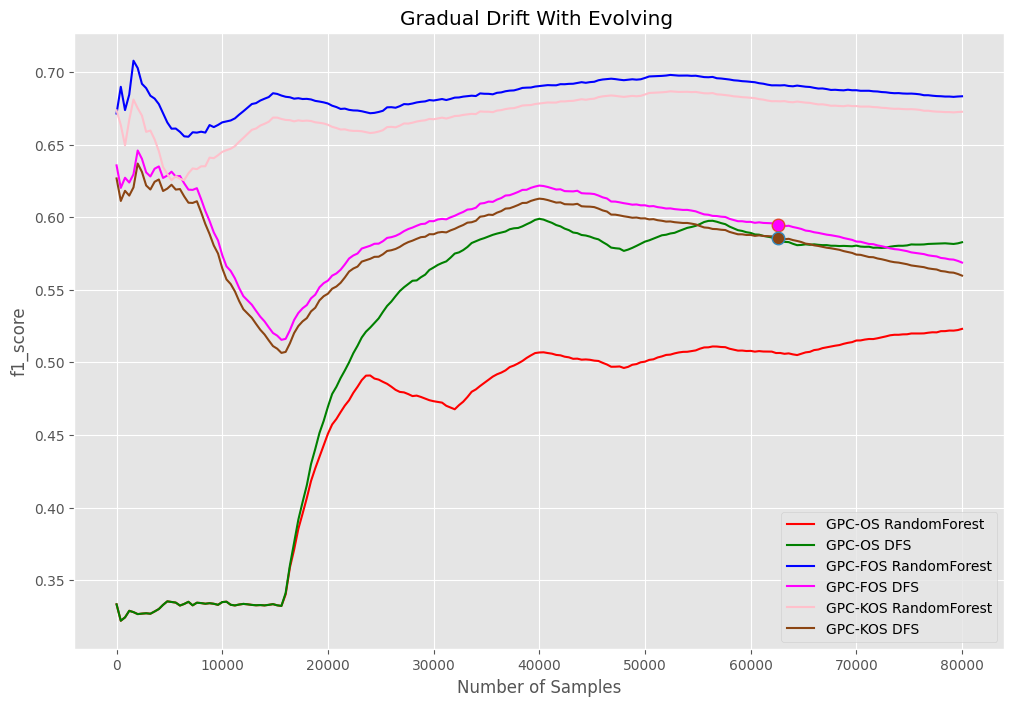

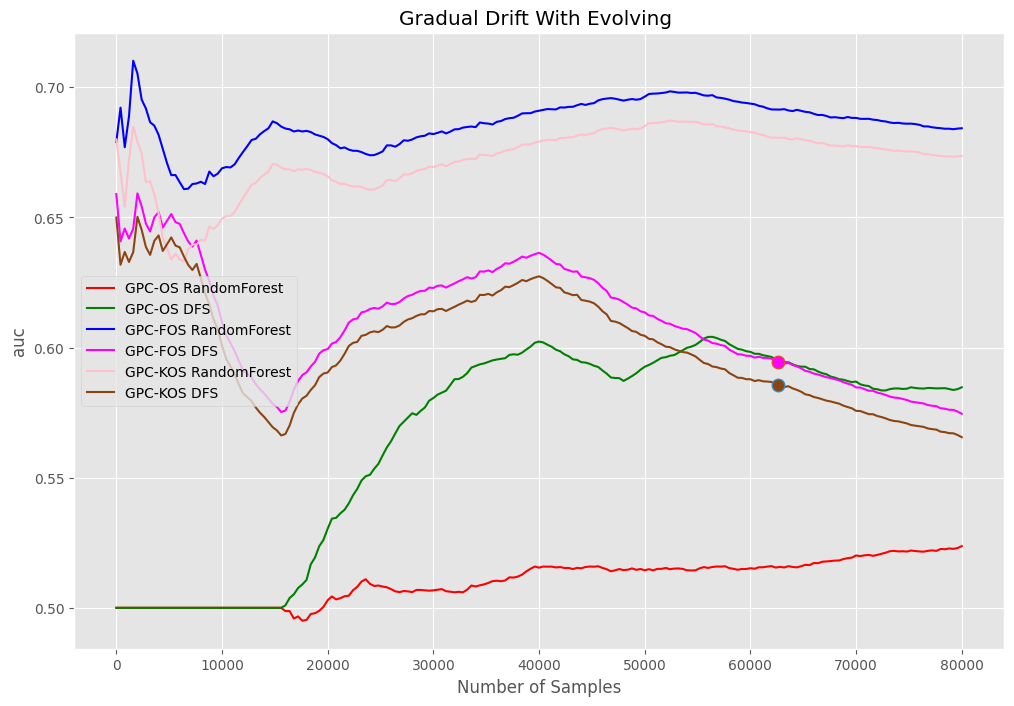

In [ ]:
gradual_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_drift_location.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=gradual_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Gradual Drift With Evolving","Gradual Drift"], metric=m, method_names=method_names) # ,_class="Zero_Class"

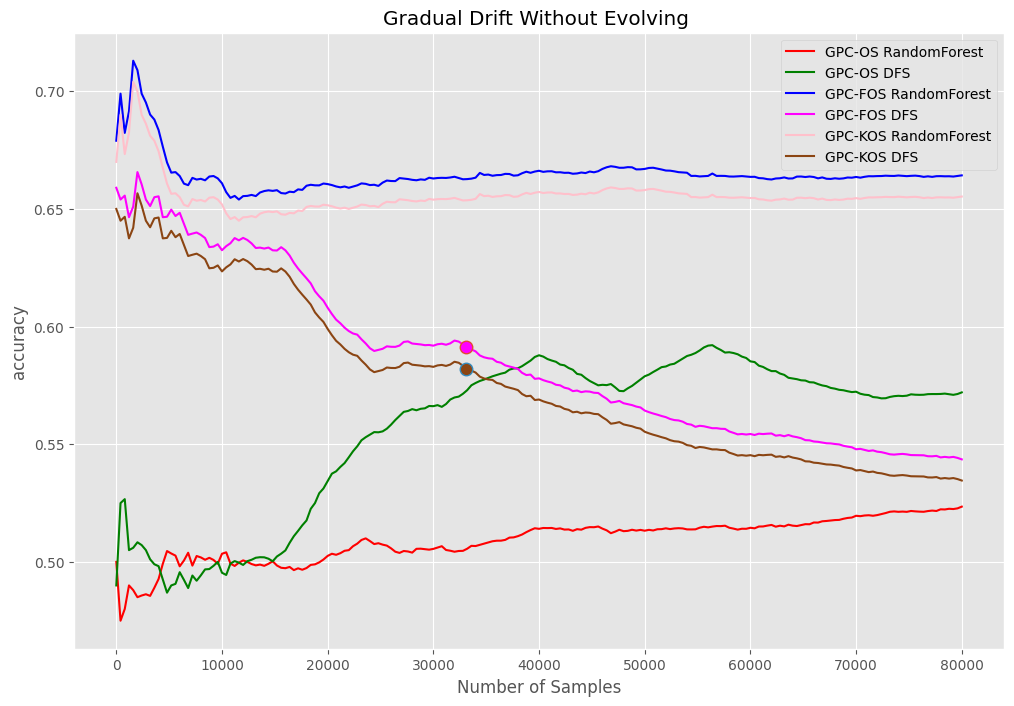

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning

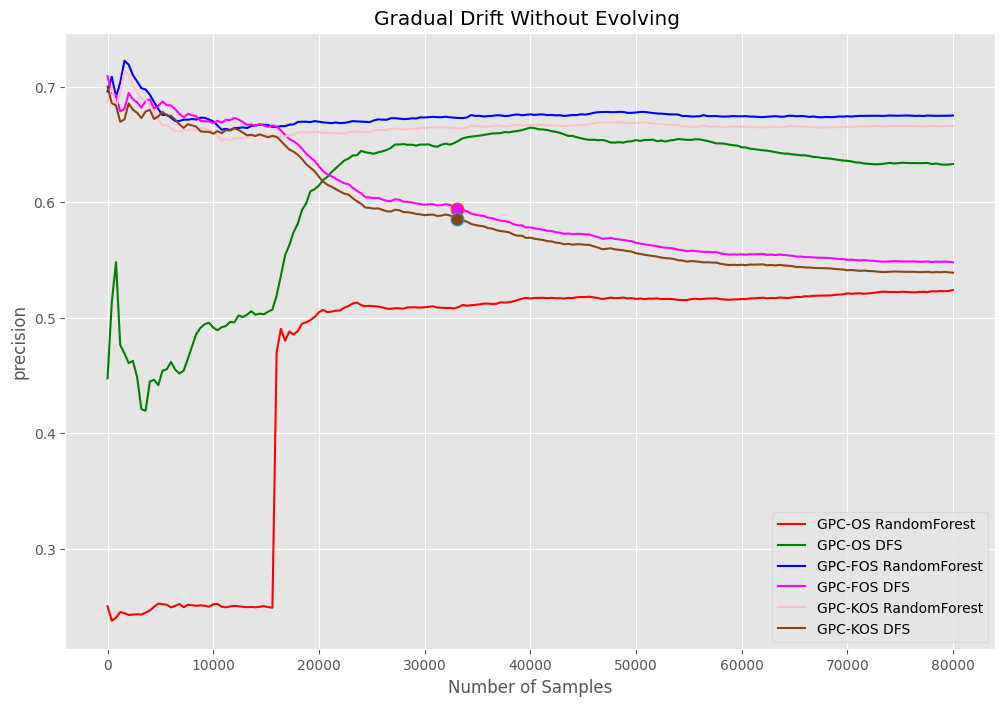

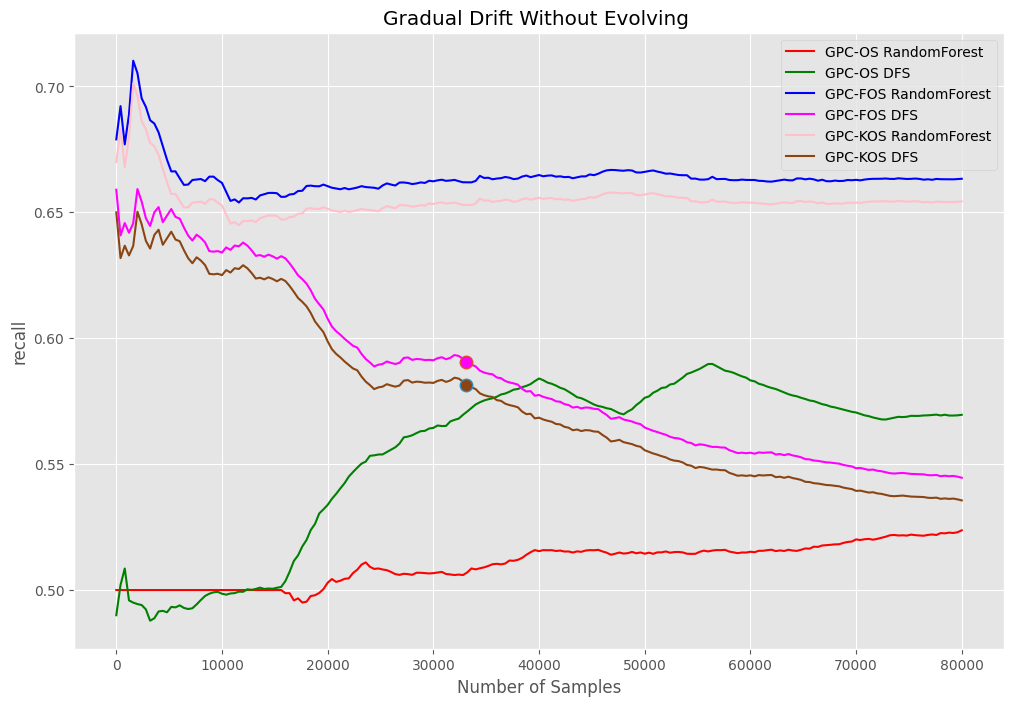

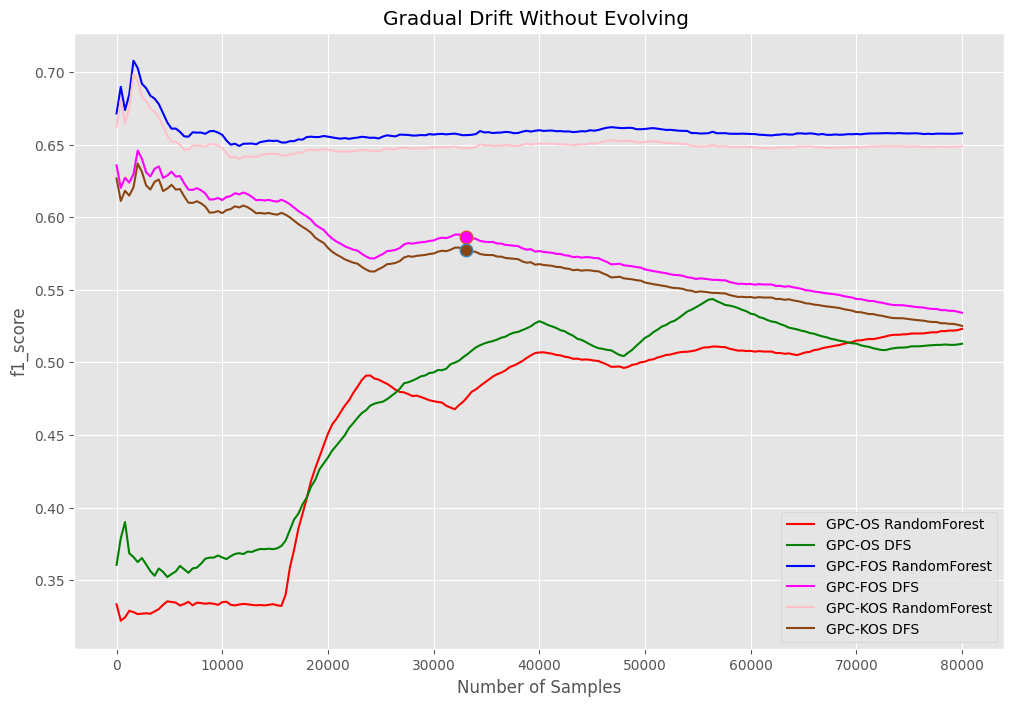

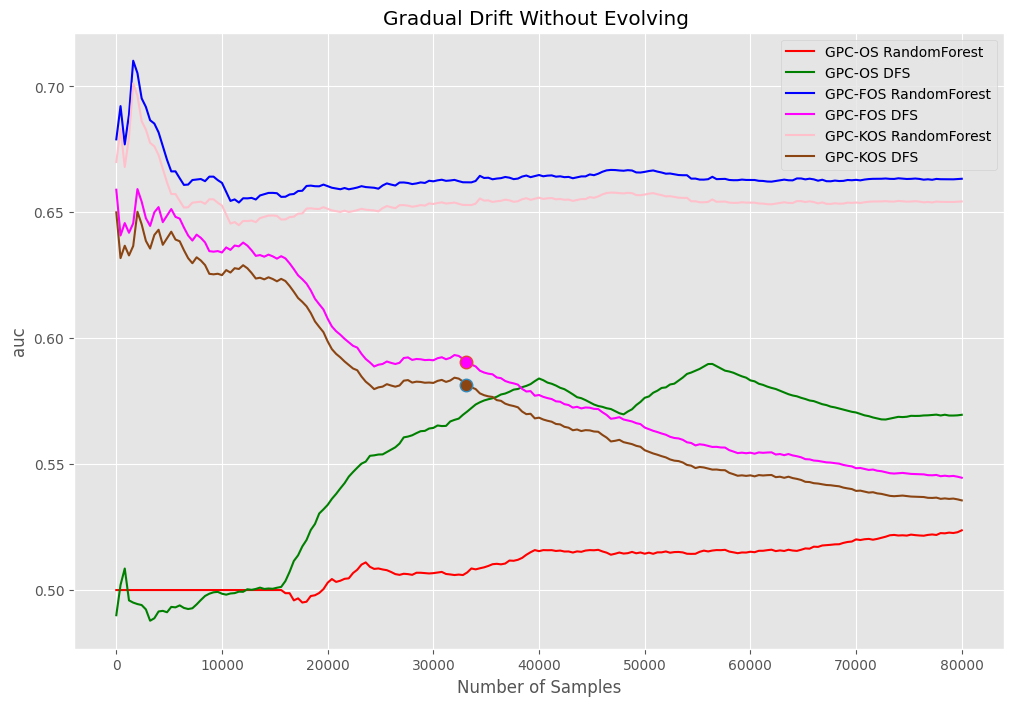

In [ ]:
gradual_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7gradualDrift.csv/7gradualDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Gradual Drift Without Evolving","Gradual Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=gradual_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["Gradual Drift Without Evolving","Gradual Drift"], metric=m, method_names=method_names,_class="One_Class")

# Blip Drift Visulization

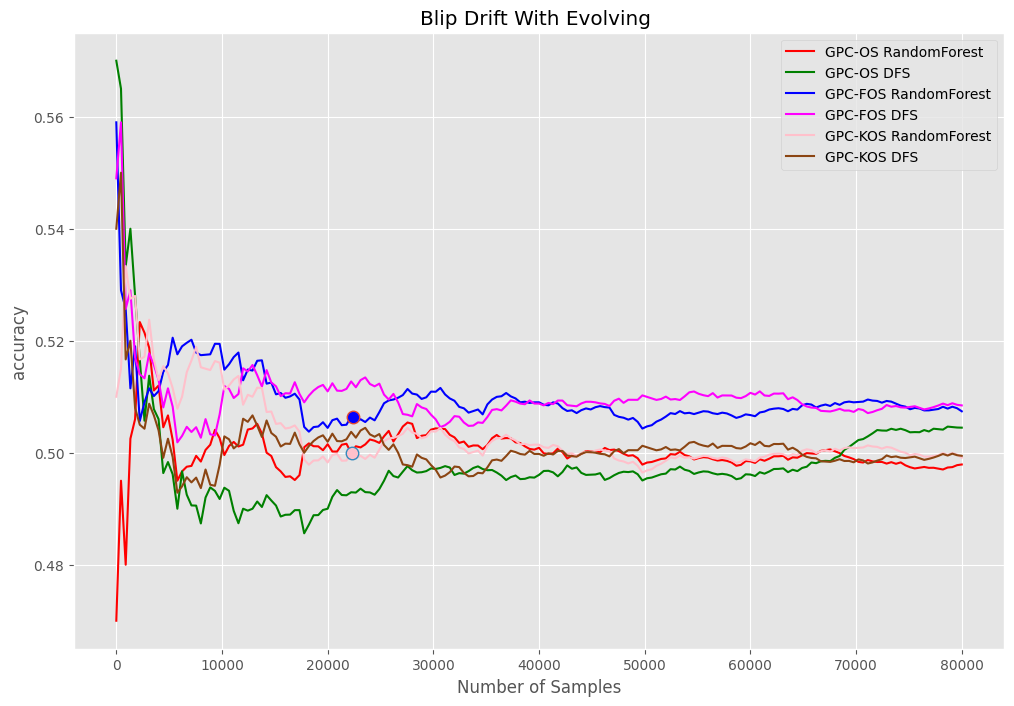

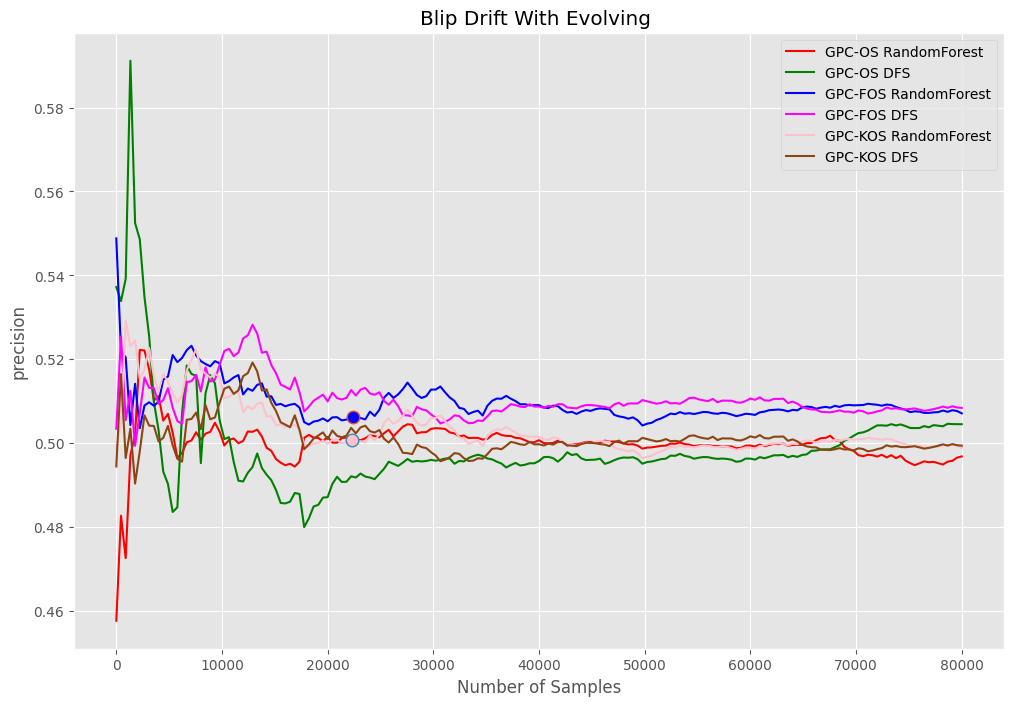

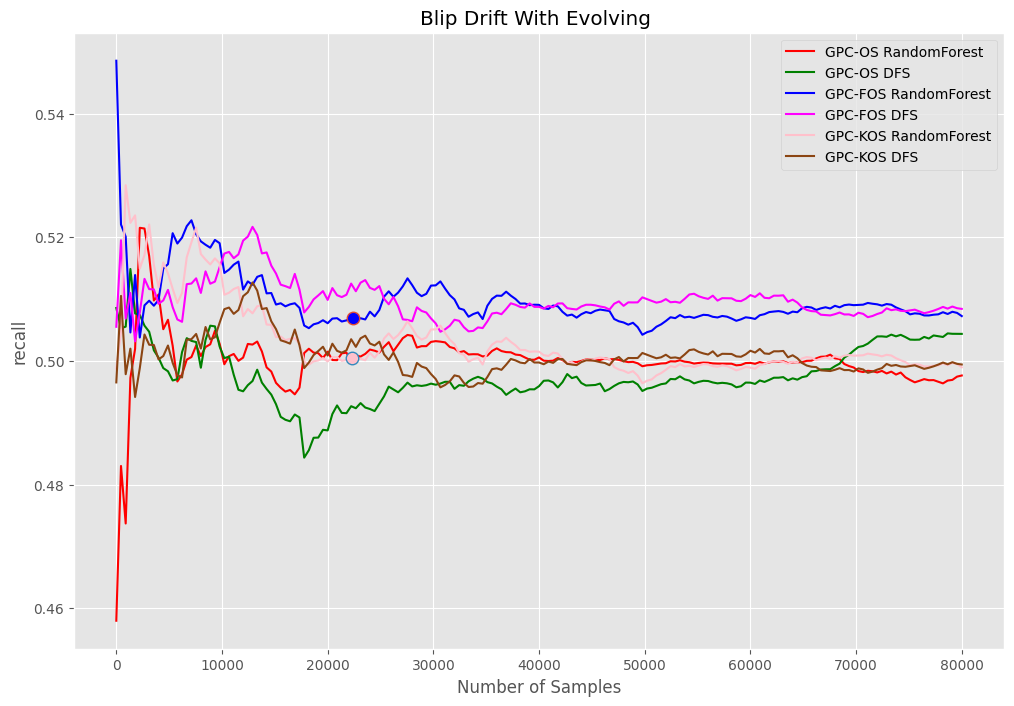

In [ ]:
blip_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Blip Drift With Evolving","Blip Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=blip_results_1, drift_data_path=drift_location_path, step_size=100,
#                   title=["Blip Drift With Evolving","Blip Drift"], metric=m, method_names=method_names,_class="One_Class")

In [ ]:
blip_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/reResultssults/ml_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/blip.csv/blip.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Blip Drift Without Evolving","Blip Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=blip_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["Blip Drift Without Evolving","Blip Drift"], metric=m, method_names=method_names,_class="One_Class")

# Recurrent Drift Visualization

In [ ]:
recurrent_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Recurrent Drift With Evolving","Recurrent Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=recurrent_results_1, drift_data_path=drift_location_path, step_size=100,
#                   title=["Recurrent Drift With Evolving","Recurrent Drift"], metric=m, method_names=method_names,_class="One_Class")

In [ ]:
recurrent_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7recurrentDrift.csv/7recurrentDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric=m, method_names=method_names)


In [ ]:
# for m in metrices:
#   time_series_plot(data_path=recurrent_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["Recurrent Drift Without Evolving","Recurrent Drift"], metric=m, method_names=method_names,_class="One_Class")

# Sudden Drift Result Visualization

In [ ]:
sudden_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Sudden Drift With Evolving","Sudden Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=sudden_results_1, drift_data_path=drift_location_path, step_size=100,
#                   title=["Sudden Drift With Evolving","Sudden Drift"], metric=m, method_names=method_names,_class="One_Class")

In [ ]:
sudden_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/7suddenDrift.csv/7suddenDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Sudden Drift Without Evolving","Sudden Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=sudden_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["Sudden Drift Without Evolving","Sudden Drift"], metric=m, method_names=method_names,_class="One_Class")

# Incremental Drift Result Visualization

In [ ]:
incremental_results_1 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                    ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["Incremental Drift With Evolving","Incremental Drift"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=incremental_results_1, drift_data_path=drift_location_path, step_size=100,
#                   title=["Incremental Drift With Evolving","Incremental Drift"], metric=m, method_names=method_names,_class="One_Class")

In [ ]:
incremental_results_2 = [
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                  #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/incrementalDrift.csv/incrementalDrift.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["Incremental Drift Without Evolving","Incremental Drift"], metric=m, method_names=method_names)


In [ ]:
# for m in metrices:
#   time_series_plot(data_path=incremental_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["Incremental Drift Without Evolving","Incremental Drift"], metric=m, method_names=method_names,_class="One_Class")

# kddcup99 Result Visualization

In [ ]:
kddcup99_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
                  title=["kddcup99 Drift With Evolving","kddcup99"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=kddcup99_results_1, drift_data_path=drift_location_path, step_size=100,
#                   title=["kddcup99 Drift With Evolving","kddcup99"], metric="precision", method_names=method_names,_class="One_Class")

In [ ]:
kddcup99_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/kddcup99_csv.csv/kddcup99_csv.csv_drift_locations_in_all_dataset.pkl",
                       ]
for m in metrices:
  time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
                  title=["kddcup99 Drift Without Evolving","kddcup99"], metric=m, method_names=method_names)

In [ ]:
# for m in metrices:
#   time_series_plot(data_path=kddcup99_results_2, drift_data_path=drift_location_path, step_size=100,
#                   title=["kddcup99 Drift Without Evolving","kddcup99"], metric="precision", method_names=method_names,_class="One_Class")

# ISCX2012 Result Visualization

In [ ]:
ISCX2012_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="precision", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="recall", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 With Evolving","ISCX2012"], metric="auc", method_names=method_names)
#   result_as_df(ISCX2012_results_1, metrices, method_names,title="ISCX2012 With Evolving")
# except:
#   print("error in path")

In [ ]:
ISCX2012_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_dynamic_feature_selection/ISCX2012.csv/ISCX2012.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="precision", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="recall", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=ISCX2012_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["ISCX2012 Without Evolving","ISCX2012"], metric="auc", method_names=method_names)
#   result_as_df(ISCX2012_results_2, metrices, method_names,title="ISCX2012 Without Evolving")
# except:
#   print("error in path")

# CSE-CIC2018 Result Visualization

In [ ]:
CSE_CIC2018_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="precision", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="recall", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 With Evolving","CSE_CIC2018"], metric="auc", method_names=method_names)
  # result_as_df(CSE_CIC2018_results_1, metrices, method_names,title="CSE_CIC2018 With Evolving")
# except:
#   print("error in path")

In [ ]:
CSE_CIC2018_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/CSE-CIC2018.csv/CSE-CIC2018.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="precision", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="recall", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CSE_CIC2018_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CSE_CIC2018 Without Evolving","CSE_CIC2018"], metric="auc", method_names=method_names)
#   result_as_df(CSE_CIC2018_results_2, metrices, method_names,title="CSE_CIC2018 Without Evolving")
# except:
#   print("error in path")

# CICIDS2017 Result Visualization

In [ ]:
CICIDS2017_results_1 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                    ]
drift_location_path = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_evolving_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="precision", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="recall", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_1, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 With Evolving","CICIDS2017"], metric="auc", method_names=method_names)
#   result_as_df(CICIDS2017_results_1, metrices, method_names,title="ISCX2012 With Evolving")
# except:
#   print("error in path")

In [ ]:
CICIDS2017_results_2 = [
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                      # "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_results.pkl",
                   ]
drift_location_path = [
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/faoselm_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/kpfaoselm_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_random_forest/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                      #  "/content/drive/My Drive/Colab Notebooks/Muawiya/Genetic Programming Combiner with DFS/Results/ml_gp_combiner_with_model_replacement_DFS/CICIDS2017.csv/CICIDS2017.csv_drift_locations_in_all_dataset.pkl",
                       ]
# try:
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="precision", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="accuracy", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="recall", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="f1_score", method_names=method_names)
time_series_plot(data_path=CICIDS2017_results_2, drift_data_path=drift_location_path, step_size=100,
                title=["CICIDS2017 Without Evolving","CICIDS2017"], metric="auc", method_names=method_names)
#   result_as_df(CICIDS2017_results_2, metrices, method_names,title="CICIDS2017 Without Evolving")
# except:
#   print("error in path")

# Bar chart plot for all datasets

In [ ]:
all_result_path = gradual_results_1 + blip_results_1 + recurrent_results_1 + sudden_results_1 + incremental_results_1 + kddcup99_results_1 + ISCX2012_results_1 + CSE_CIC2018_results_1 + CICIDS2017_results_1
data_set_names = ['Gradual', 'Blip', 'Recurrent', 'Sudden', 'Incremental', 'KDDCUP99', 'ISCX2012', 'CSE-CIC2018', 'CICIDS2017']

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Accuracy Comparision With Evolving", metric="accuracy", method_names=method_names, xticks=data_set_names) # Synthetic

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Precision Comparision With Evolving", metric="precision", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Recall Comparision With Evolving", metric="recall", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="F1_score Comparision With Evolving", metric="f1_score", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Auc Comparision With Evolving", metric="auc", method_names=method_names, xticks=data_set_names)

In [ ]:
all_result_path = gradual_results_2 + blip_results_2 + recurrent_results_2 + sudden_results_2 + incremental_results_2 + kddcup99_results_2 + ISCX2012_results_2 + CSE_CIC2018_results_2 + CICIDS2017_results_2
data_set_names = ['Gradual', 'Blip', 'Recurrent', 'Sudden', 'Incremental', 'KDDCUP99', 'ISCX2012', 'CSE-CIC2018', 'CICIDS2017']

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Accuracy Comparision Without Evolving", metric="accuracy", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Precision Comparision Without Evolving", metric="precision", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Recall Comparision Without Evolving", metric="recall", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="F1_score Comparision Without Evolving", metric="f1_score", method_names=method_names, xticks=data_set_names)

In [ ]:
bar_chart_plot(data_path=all_result_path,
               title="Auc Comparision Without Evolving", metric="auc", method_names=method_names, xticks=data_set_names)